In [1]:
using NNlib
using LaTeXStrings
using Plots

# Defining spline transformation

In [2]:
"""
    spline_trafo(widths::AbstractVector, heigths::AbstractVector, derivatives::AbstractVector, trafo::String)

Create a spline transformation object. 

'trafo' ∈ ["rqs", "rqs_inverse", "rls", "rls_inverse"] specifies which type of spline is to be used, defaults to 'trafo = "rqs"'.

'trafo' = "rqs" or "rqs_inverse" implements a rational quadratic spline or its inverse as defined in [1]
'trafo' = "rls" or "rls_inverse" implements a rational linear spline or its inverse as defined in [2]

'widths', 'heights' and 'derivatives' must satisfy the following constraints:

    widths[i] <= widths[i + 1] 
    heigths[i] <= heights[i + 1]
        
    widths[1] = heigths[1] = -B with [-B, B] being the desired interval mask
    widths[end] = heigths[end] = B

    length(widths) = length(heigths) = (length(derivatives) + 1) = K (= desired number of bins into which to partition the input interval)

To use a spline transformation on an univariate input do for example:

    julia> rqs = spline_trafo(widths, heights, derivatives, "rqs")
    julia> rqs(0.4)

Where widths, heights and derivatives are the values parameterizing your desired interval mask, and 0.4 the value you wish to transform.

Passing a multivariate input to such a transfromation brodcasts the univariate trafo over the multivariate input vector.

[1] 'Neural Spline Flows' Papamakarios et al 
[2] 'Invertible Generative Modeling using Linear Rational Splines' Dolatabadi et al
"""
struct spline_trafo{P<:AbstractVector}
    widths::P
    heights::P
    derivatives::P
    trafo::String 
end

function (g::spline_trafo{<:AbstractVector})(x::Real)
    return spline_univariate(g.widths, g.heights, g.derivatives, x; g.trafo)
end

(g::spline_trafo{<:AbstractVector})(x::AbstractVector) = g.(x)

function spline_univariate(
    widths::AbstractVector,
    heights::AbstractVector,
    derivatives::AbstractVector,
    x::Real;
    trafo::String = "rqs"
)
    if !(trafo in ["rqs", "rqs_inverse", "rls", "rls_inverse"])
        throw(ArgumentError("Please select a valid trafo keyword: trafo ∈ [\"rqs\", \"rqs_inverse\", \"rls\", \"rls_inverse\"]"))
    end

    T = promote_type(eltype(widths), eltype(heights), eltype(derivatives), eltype(x))

    # Number of bins K
    K = length(widths)
    
    # Find in which bin x lies, -1 is so bin idxs start at k = 0
    if trafo == "rqs" || trafo == "rls"
        k = searchsortedfirst(widths, x) - 1 
    else 
        k = searchsortedfirst(heights, x) - 1 
    end

    # If x outside interval mask apply identity transform
    if (k >= K) || (k == 0)
        return (one(T) * x, (trafo == "rqs" || trafo == "rls") ? zero(T) * x : nothing)
    end

    # Width
    # If k == 0 put it in the bin `[-B, widths[1]]`
    w_k = widths[k] #(k == 0) ? -widths[end] :
    w = widths[k + 1] - w_k

    # Height
    h_k = heights[k] # (k == 0) ? -heights[end] : 
    h_kplus1 = (k == K) ? heights[end] : heights[k + 1]
    
    # Slope 
    Δy = heights[k + 1] - h_k
    s = Δy / w

    # Derivatives
    d_k = derivatives[k] #(k == 0) ? one(T) :
    d_kplus1 = (k == K - 1) ? one(T) : derivatives[k + 1]
    
    params = [x, w_k, w, h_k, h_kplus1, Δy, s, d_k, d_kplus1]

    if trafo == "rqs"
        return rqs_forward(params...)

    elseif trafo == "rqs_inverse"
        return rqs_inverse(params...)

    elseif trafo == "rls"
        return rls_forward(params...)

    elseif trafo == "rls_inverse"
        return rls_inverse(params...)

    end
end


function rqs_forward(x::Real, w_k::Real, w::Real, h_k::Real, h_kplus1::Real, Δy::Real, s::Real, d_k::Real, d_kplus1::Real)

    ξ = (x - w_k) / w
    # Eq. (14) from [1]
    numerator = Δy * (s * ξ^2 + d_k * ξ * (1 - ξ))
    numerator_jl = s^2 * (d_kplus1 * ξ^2 + 2 * s * ξ * (1 - ξ) + d_k * (1 - ξ)^2)

    denominator = s + (d_kplus1 + d_k - 2s) * ξ * (1 - ξ)

    g = h_k + numerator / denominator
    logjac = log(numerator_jl) - 2 * log(denominator)

    return (g, logjac)
end

function rqs_inverse(x::Real, w_k::Real, w::Real, h_k::Real, h_kplus1::Real, Δy::Real, s::Real, d_k::Real, d_kplus1::Real)

    ds = d_kplus1 + d_k - 2 * s

    # Eq.s (25) through (27) from [1]
    a1 = Δy * (s - d_k) + (x - h_k) * ds
    a2 = Δy * d_k - (x - h_k) * ds
    a3 = - s * (x - h_k)

    # Eq. (24) from [1]. There's a mistake in the paper; says `x` but should be `ξ`
    numerator = - 2 * a3
    denominator = (a2 + sqrt(a2^2 - 4 * a1 * a3))
    ξ = numerator / denominator

    g = ξ * w + w_k
    return (g, nothing)
end

function rls_forward(x::Real, w_k::Real, w::Real, h_k::Real, h_kplus1::Real, Δy::Real, s::Real, d_k::Real, d_kplus1::Real)
    
    lam = 0.95 * sigmoid(0.5) + 0.025 # arbitrary value, sigmoid should take unnormalized_lambda as another free param.
    wa  = 1
    wb  = sqrt(d_k / d_kplus1) * wa
    wc  = (lam * wa * d_k + (1 - lam) * wb *  d_kplus1) / s
    yc  = ((1 - lam) * wa * h_k + lam * wb * h_kplus1)/ ((1 - lam) * wa + lam * wb)

    # the boolean factors determine in which 'virtual bin' the input x lies (see [2]], sec. 3.2)
    numerator = (lam * wa * (h_k - x)) * float(x <= yc) + ((wc - lam * wb) * x + lam * wb * h_kplus1 - wc * yc) * float(x > yc)

    denominator = ((wc - wa) * x + wa * h_k - wc * yc) * float(x <= yc) + ((wc - wb) * x + wb * h_kplus1 - wc * yc) * float(x > yc)

    theta = numerator / denominator

    g = w_k + theta * w

    derivative_numerator = (wa * wc * lam * (yc - h_k) * float(x <= yc) + wb * wc * (1 - lam) * (h_kplus1 - yc) * float(x > yc)) * w_k

    logjac = log(derivative_numerator) - 2 * log(abs(denominator))

    return (g, logjac)
end

function rls_inverse(x::Real, w_k::Real, w::Real, h_k::Real, h_kplus1::Real, Δy::Real, s::Real, d_k::Real, d_kplus1::Real)

    lam = 0.95 * sigmoid(0.5) + 0.025 
    wa  = 1
    wb  = sqrt(d_k / d_kplus1) * wa
    wc  = (lam * wa * d_k + (1 - lam) * wb *  d_kplus1) / s
    yc  = ((1 - lam) * wa * h_k + lam * wb * h_kplus1)/ ((1 - lam) * wa + lam * wb)

    theta = (x - w_k) / w

    numerator = (wa * h_k * (lam - theta) + wc * yc * theta) * float(theta <= lam) + (wc * yc * (1 - theta) + wb * h_kplus1 * (theta - lam)) * float(theta > lam)

    denominator = (wa * (lam - theta) + wc * theta) * float(theta <= lam) + (wc * (1 - theta) + wb * (theta - lam)) * float(theta > lam)

    g = numerator / denominator

    derivative_numerator = (wa * wc * lam * (yc - h_k) * float(theta <= lam) + wb * wc * (1 - lam) * (h_kplus1 - yc) * float(theta > lam)) / w_k

    logjac = log(derivative_numerator) - 2 * log(abs(denominator))

    return g, logjac
end 

rls_inverse (generic function with 1 method)

# Visualization:

In [3]:
# Create mock inverval mask (needs to satisfy constraints as specified in spline_trafo() docstring):

widths = [-1, -0.9, -0.6, -0.1, 0.4, 0.9, 1.0]
heigths = [-1, -0.9, -0.6, -0.1, 0.4, 0.9, 1.0]
derivatives = [0.4, 0.5, 1.2, 0.5, 0.1, 1.9]

# For linear rational spline:
# (The linear rational spline currently only supports positive input values. I'm working on fixing that)
widths_pos = [0.0, 0.1, 0.4, 0.6, 0.65, 0.8, 1.0]
heigths_pos = [0.0, 0.1, 0.4, 0.6, 0.65, 0.8, 1.0]

7-element Vector{Float64}:
 0.0
 0.1
 0.4
 0.6
 0.65
 0.8
 1.0

In [4]:
# Create different spline transformation objects, using above intervals:
rqs = spline_trafo(widths, heigths, derivatives, "rqs")

rqs_inv = spline_trafo(widths, heigths, derivatives, "rqs_inverse")

rls = spline_trafo(widths_pos, heigths_pos, derivatives, "rls")

rls_inv = spline_trafo(widths_pos, heigths_pos, derivatives, "rls_inverse")

spline_trafo{Vector{Float64}}([0.0, 0.1, 0.4, 0.6, 0.65, 0.8, 1.0], [0.0, 0.1, 0.4, 0.6, 0.65, 0.8, 1.0], [0.4, 0.5, 1.2, 0.5, 0.1, 1.9], "rls_inverse")

### Plot 

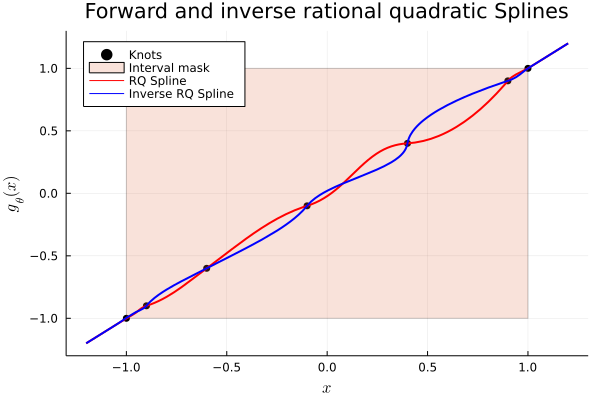

In [5]:
# Forward and inverse rational quadratic splines

rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h]) # for interval mask

plot(widths, heigths, seriestype = :scatter, markercolor = :black, label = "Knots", legend = :topleft)
plot!(rectangle(2,2,-1,-1), opacity=.2, label = "Interval mask")
plot!(title = "Forward and inverse rational quadratic Splines", xlabel = L"$x$", ylabel = L"$g_{\theta}(x)$")
xlims!(-1.3, 1.3)
ylims!(-1.3, 1.3)

plot!(x -> rqs(x)[1], -1.2, 1.2, linewidth = 2.0, linecolor = :red, label = "RQ Spline")
plot!(x -> rqs_inv(x)[1], -1.2, 1.2, linewidth = 2.0, linecolor = :blue, label = "Inverse RQ Spline")

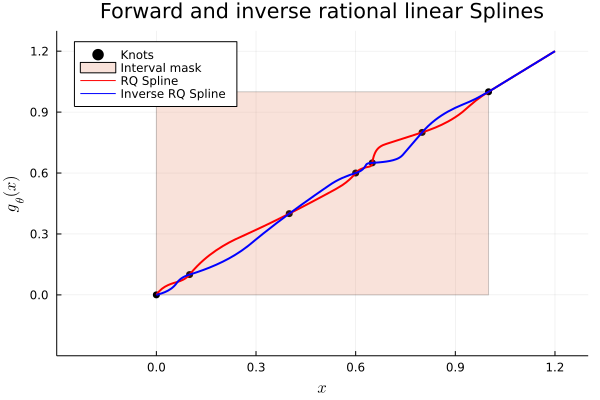

In [6]:
# Forward and inverse rational linear splines (currently only support positive inputs)

plot(widths_pos, heigths_pos, seriestype = :scatter, markercolor = :black, label = "Knots", legend = :topleft)
plot!(rectangle(1,1,0,0), opacity=.2, label = "Interval mask")
plot!(title = "Forward and inverse rational linear Splines", xlabel = L"$x$", ylabel = L"$g_{\theta}(x)$")
xlims!(-0.3, 1.3)
ylims!(-0.3, 1.3)

plot!(x -> rls(x)[1], -0.0, 1.2, linewidth = 2.0, linecolor = :red, label = "RQ Spline")
plot!(x -> rls_inv(x)[1], -0.0, 1.2, linewidth = 2.0, linecolor = :blue, label = "Inverse RQ Spline")